#Loading Library

In [1]:
# pandas
import pandas as pd

# numpy
import numpy as np

# defaultcit
from collections import defaultdict

# plot with folium
import folium
from IPython.core.display import HTML

# parsing time
from datetime import datetime, timedelta

# plotting with matplotlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# plotting with pylab
import pylab as P

# Clustering
from sklearn.cluster import MiniBatchKMeans, KMeans
import time
import json

# change prediction categories into labels
from sklearn import preprocessing
from sklearn import cross_validation 
from sklearn import svm
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns
import re

###Loading Training/Testing Data

In [26]:
#test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")
train_df = train_df.sample(n = 500000, random_state = 666)

In [21]:
train_df = pd.DataFrame(train_df)
train_df = train_df.reset_index(drop=True)
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2003-04-02 13:00:00,ASSAULT,THREATS AGAINST LIFE,Wednesday,PARK,NONE,500 Block of CORBETT AV,-122.444182,37.757346
1,2011-12-15 16:15:00,LARCENY/THEFT,GRAND THEFT PICKPOCKET,Thursday,CENTRAL,NONE,300 Block of BAY ST,-122.412804,37.805774
2,2015-03-04 01:55:00,LARCENY/THEFT,GRAND THEFT FROM PERSON,Wednesday,MISSION,NONE,400 Block of CASTRO ST,-122.435150,37.761760
3,2008-08-19 22:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,NORTHERN,NONE,2000 Block of WASHINGTON ST,-122.427007,37.792582
4,2014-04-16 12:58:00,DRUG/NARCOTIC,SALE OF BASE/ROCK COCAINE,Wednesday,TENDERLOIN,"ARREST, BOOKED",TURK ST / HYDE ST,-122.415695,37.782585


In [5]:
#Look at the shape
train_df.shape

(20000, 9)

In [6]:
train_df.columns, train_df.dtypes

(Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
        'Resolution', 'Address', 'X', 'Y'],
       dtype='object'), Dates          object
 Category       object
 Descript       object
 DayOfWeek      object
 PdDistrict     object
 Resolution     object
 Address        object
 X             float64
 Y             float64
 dtype: object)

In [7]:
#Listing Unique values for columns
pd.unique(train_df.PdDistrict.ravel()), pd.unique(train_df.DayOfWeek.ravel()), pd.unique(train_df.Category.ravel()),\
pd.unique(train_df.Resolution .ravel())
#pd.unique(train_df.hour_of_day.ravel())

(array(['PARK', 'CENTRAL', 'MISSION', 'NORTHERN', 'TENDERLOIN', 'INGLESIDE',
        'TARAVAL', 'SOUTHERN', 'BAYVIEW', 'RICHMOND'], dtype=object),
 array(['Wednesday', 'Thursday', 'Tuesday', 'Friday', 'Saturday', 'Monday',
        'Sunday'], dtype=object),
 array(['ASSAULT', 'LARCENY/THEFT', 'DRUG/NARCOTIC', 'VEHICLE THEFT',
        'ROBBERY', 'WARRANTS', 'BURGLARY', 'SEX OFFENSES FORCIBLE',
        'VANDALISM', 'OTHER OFFENSES', 'PROSTITUTION', 'NON-CRIMINAL',
        'MISSING PERSON', 'TRESPASS', 'SUSPICIOUS OCC', 'WEAPON LAWS',
        'FORGERY/COUNTERFEITING', 'FRAUD', 'DISORDERLY CONDUCT',
        'SEX OFFENSES NON FORCIBLE', 'SECONDARY CODES',
        'DRIVING UNDER THE INFLUENCE', 'DRUNKENNESS', 'RUNAWAY', 'GAMBLING',
        'RECOVERED VEHICLE', 'STOLEN PROPERTY', 'LOITERING', 'KIDNAPPING',
        'EMBEZZLEMENT', 'ARSON', 'FAMILY OFFENSES', 'LIQUOR LAWS',
        'BAD CHECKS', 'BRIBERY', 'SUICIDE', 'EXTORTION'], dtype=object),
 array(['NONE', 'ARREST, BOOKED', 'JUVENILE BOOKED

In [194]:
# dtDate = datetime.strptime("07-27-2012","%m-%d-%Y")
datetime.strptime('2015-05-13 23:53:00', "%Y-%m-%d %H:%M:%S")

datetime.datetime(2015, 5, 13, 23, 53)

#Feature Creation

In [27]:
def createFeature(train_df):
    #Getting Month of Year, Day of Month, Hour of Day, and Minute of Hour
    month_of_year = []
    day_of_month =[]
    hour_of_day =[]
    min_of_hour =[]
    for i in range(len(train_df.Dates.values)):
        moy = datetime.strptime(train_df.Dates.values[i], "%Y-%m-%d %H:%M:%S").month
        dom = datetime.strptime(train_df.Dates.values[i], "%Y-%m-%d %H:%M:%S").day
        hod = datetime.strptime(train_df.Dates.values[i], "%Y-%m-%d %H:%M:%S").hour
        moh = datetime.strptime(train_df.Dates.values[i], "%Y-%m-%d %H:%M:%S").minute
        month_of_year.append(moy)
        day_of_month.append(dom)
        hour_of_day.append(hod)
        min_of_hour.append(moh)
    train_df['month_of_year'] = month_of_year #Month of the Year feature added
    train_df['day_of_month'] = day_of_month # Day of Month feature added
    train_df['hour_of_day'] = hour_of_day # Hour of Day feature added
    train_df['min_of_hour'] = min_of_hour # Minute of Hour Feature added
    
    #Creating Weeekday/Weekended Feature
    train_df['WeekdayWeeekend'] = train_df['DayOfWeek'].map( {'Monday': 'Weekday', 'Tuesday': 'Weekday', \
                                                          'Wednesday': 'Weekday', 'Thursday': 'Weekday', 'Friday': 'Weekend',\
                                                         'Saturday': 'Weekend', 'Sunday': 'Weekday'} ).astype(object)
    # Creating Midnight/Morning/Afternoon/Night Column
    train_df['TimeOfDay'] = train_df['hour_of_day'].map({0: 'Midnight', 1: 'Midnight', 2:'Midnight', 3:'Midnight', 4:'Morning', \
                                                     5:'Morning', 6:'Morning', 7:'Morning', 8:'Morning', 9:'Morning', \
                                                     10:'Morning', 11:'Morning', 12:'Afternoon', 13:'Afternoon', 14:'Afternoon', \
                                                     15:'Afternoon', 16:'Afternoon', 17:'Afternoon', 18:'Night', 19:'Night', \
                                                     20:'Night', 21:'Night', 22:'Midnight', 23:'Midnight'}).astype(object)
    # Creating Season Feature
    train_df['Season'] = train_df['month_of_year'].map({1: 'Winter', 2: 'Winter', 3:'Spring', 4:'Spring', 5:'Spring', \
                                                     6:'Spring', 7:'Summer', 8:'Summer', 9:'Summer', 10:'Autumn', \
                                                     11:'Autumn', 12:'Winter'}).astype(object)

    
    
    train_df['Crime_Type'] = train_df['Category'].map({'FRAUD': 'White', 'FORGERY/COUNTERFEITING': 'White',
                                                      'BAD CHECKS': 'White', 'EXTORTION': 'White', 'EMBEZZLEMENT': 'White',
                                                       'SUSPICIOUS OCC': 'White', 'BRIBERY': 'White', 'VANDALISM': 'Blue',
                                                       'LARCENY/THEFT': 'Blue', 'STOLEN PROPERTY': 'Blue', 'ROBBERY': 'Blue',
                                                       'DRIVING UNDER THE INFLUENCE': 'Blue', 'DISORDERLY CONDUCT': 'Blue',
                                                       'LIQUOR LAWS': 'Blue', 'VEHICLE THEFT': 'Blue', 'ASSAULT': 'Blue',
                                                       'KIDNAPPING': 'Blue', 'TRESPASS': 'Blue', 'ARSON': 'Blue', 
                                                       'RECOVERED VEHICLE': 'Blue', 'MISSING PERSON': 'Other', 'RUNAWAY': 'Other',
                                                       'FAMILY OFFENSES': 'Other', 'SEX OFFENSES NON FORCIBLE': 'Other',
                                                       'PORNOGRAPHY/OBSCENE MAT': 'Other', 'WEAPON LAWS': 'Other',
                                                       'DRUNKENNESS': 'Other', 'SUICIDE': 'Other', 'TREA': 'Other',
                                                       'DRUG/NARCOTIC': 'Other', 'SEX OFFENSES FORCIBLE': 'Other', 
                                                       'LOITERING': 'Other'
                                                      }).astype(object)
    
    train_df['District_Type'] = train_df['PdDistrict'].map({'PARK': 'Other', 'CENTRAL': 'Other', 'MISSION': 'Corner', 'NORTHERN': 'Corner', 
                                                              'TENDERLOIN': 'Other', 'INGLESIDE': 'Street', 'TARAVAL': 'Street', 
                                                              'SOUTHERN': 'Other', 'BAYVIEW': 'Other', 'RICHMOND': 'Other'}).astype(object)

        
    #Deleting features not needed
    train_df = train_df.drop('Descript', 1)
    train_df = train_df.drop('Resolution', 1)
    train_df = train_df.drop('Address', 1)
    
    #Creating Dummy Variables
    WeekdayWeekend_dummies = pd.get_dummies(train_df.WeekdayWeeekend)
    TimeOfDay_dummies = pd.get_dummies(train_df.TimeOfDay)
    season_dummies = pd.get_dummies(train_df.Season)
    district_dummies = pd.get_dummies(train_df.PdDistrict)
    week_dummies = pd.get_dummies(train_df.DayOfWeek)
    type_dummies = pd.get_dummies(train_df.Crime_Type)
    corner_dummies = pd.get_dummies(train_df.District_Type)
    
    train_df_new = pd.concat([train_df, WeekdayWeekend_dummies, TimeOfDay_dummies, season_dummies, district_dummies, week_dummies, type_dummies, corner_dummies], axis=1, join_axes=[train_df.index])
    print('Sanity Check')
    print(train_df.shape)
    print(WeekdayWeekend_dummies.shape)
    print(TimeOfDay_dummies.shape)
    print(season_dummies.shape)
    print(district_dummies.shape)
    print(week_dummies.shape)
    print(type_dummies.shape)
    print(corner_dummies.shape)
    print(train_df_new.shape)
    print('Make sure the total adds up to the last number')
    
    le_crime = preprocessing.LabelEncoder()
    crime = le_crime.fit_transform(train_df_new.Category)
    train_df_new['dummy_Category'] = crime

    return train_df_new
#Calling the feature creation function
train_df_new = createFeature(train_df)
train_df_new.head()

Sanity Check
(500000, 15)
(500000, 2)
(500000, 4)
(500000, 4)
(500000, 10)
(500000, 7)
(500000, 3)
(500000, 3)
(500000, 48)
Make sure the total adds up to the last number


,Dates,Category,DayOfWeek,PdDistrict,X,Y,month_of_year,day_of_month,hour_of_day,min_of_hour,...,Thursday,Tuesday,Wednesday,Blue,Other,White,Corner,Other,Street,dummy_Category
859451,2003-04-02 13:00:00,ASSAULT,Wednesday,PARK,-122.444182,37.757346,4,2,13,0,...,0,0,1,1,0,0,0,1,0,1
253119,2011-12-15 16:15:00,LARCENY/THEFT,Thursday,CENTRAL,-122.412804,37.805774,12,15,16,15,...,1,0,0,1,0,0,0,1,0,16
14837,2015-03-04 01:55:00,LARCENY/THEFT,Wednesday,MISSION,-122.435150,37.761760,3,4,1,55,...,0,0,1,1,0,0,1,0,0,16
478492,2008-08-19 22:00:00,LARCENY/THEFT,Tuesday,NORTHERN,-122.427007,37.792582,8,19,22,0,...,0,1,0,1,0,0,1,0,0,16
81259,2014-04-16 12:58:00,DRUG/NARCOTIC,Wednesday,TENDERLOIN,-122.415695,37.782585,4,16,12,58,...,0,0,1,0,1,0,0,1,0,7


#Exploring with Street Corner Feature

[[ 70.56629245  71.13128319  64.97517845  62.23151556  70.05954795
   77.89581752  78.43550669  71.06256229  70.14820318  75.14616487  70.3448    ]
 [ 29.43370755  28.86871681  35.02482155  37.76848444  29.94045205
   22.10418248  21.56449331  28.93743771  29.85179682  24.85383513  29.6552    ]]


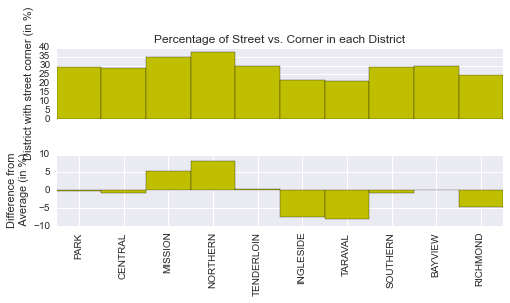

In [28]:
train_df['street_corner'] = train_df['Address'].apply(lambda x: 1 if '/' in x else 0)
crime_categories = train_df['PdDistrict'].unique()
n_district = crime_categories.shape[0]
street_corner_percentages = np.zeros((2,n_district+1))

for n in np.arange(n_district):
    if 0 in train_df['street_corner'].loc[train_df['PdDistrict'] == crime_categories[n]].value_counts().keys():
        street_corner_percentages[0,n] = train_df['street_corner'].loc[train_df['PdDistrict'] == crime_categories[n]].value_counts()[0]	
    if 1 in train_df['street_corner'].loc[train_df['PdDistrict'] == crime_categories[n]].value_counts().keys():
        street_corner_percentages[1,n] = train_df['street_corner'].loc[train_df['PdDistrict'] == crime_categories[n]].value_counts()[1]	

street_corner_percentages[:,-1] = np.sum(street_corner_percentages, axis=1)
street_corner_percentages = 100.0*(street_corner_percentages/np.sum(street_corner_percentages, axis=0))
print(street_corner_percentages)

ind = np.arange(n_district)
width = 1.0

fig, axarr = plt.subplots(2,1)
rects2 = axarr[0].bar(ind, street_corner_percentages[1,:-1], width, color='y')
rects3 = axarr[1].bar(ind, street_corner_percentages[1,:-1]-street_corner_percentages[1,-1], width, color='y')

axarr[0].set_ylabel('District with street corner (in %)')
axarr[1].set_ylabel('Difference from \n Average (in %)')
axarr[0].set_title('Percentage of Street vs. Corner in each District')
axarr[0].set_xticks(ind+0.5*width)
axarr[1].set_xticks(ind+0.5*width)

fig.subplots_adjust(hspace=.5)
crimes_list = list(crime_categories)
axarr[1].set_xticklabels(crimes_list, rotation='vertical')
axarr[0].get_xaxis().set_ticks([])
plt.subplots_adjust(bottom=0.45)
plt.savefig('breakdown_of_corner_by_district.png')
#code reference https://www.kaggle.com/tfurmston/sf-crime/crimes-that-occur-on-a-street-corner/code

In [281]:
## Checking the calculation is right
Park_boolean = train_df['PdDistrict'] == 'PARK'
train_df_park = train_df[Park_boolean]
train_df_park['street_corner_park'] = train_df_park[Park_boolean]['Address'].apply(lambda x: 1 if '/' in x else 0)
len(train_df_park[train_df_park['street_corner_park'] == 0])

//anaconda/envs/py3k/lib/python3.3/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


799

In [16]:
train_df_new.columns

Index(['Dates', 'Category', 'DayOfWeek', 'PdDistrict', 'X', 'Y',
       'month_of_year', 'day_of_month', 'hour_of_day', 'min_of_hour',
       'WeekdayWeeekend', 'TimeOfDay', 'Season', 'Crime_Type', 'District_Type',
       'Weekday', 'Weekend', 'Afternoon', 'Midnight', 'Morning', 'Night',
       'Autumn', 'Spring', 'Summer', 'Winter', 'BAYVIEW', 'CENTRAL',
       'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN',
       'TARAVAL', 'TENDERLOIN', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', 'Blue', 'Other', 'White', 'Corner',
       'Other', 'Street', 'dummy_Category'],
      dtype='object')

In [53]:
#Take a peek at the frequency of categories
categories_dict = defaultdict(int)
for item in train_df_new.Category:
    categories_dict[item] += 1
(sorted(categories_dict.items(), key=lambda x: x[1], reverse=True))

[('LARCENY/THEFT', 9987),
 ('OTHER OFFENSES', 7194),
 ('NON-CRIMINAL', 5238),
 ('ASSAULT', 4404),
 ('DRUG/NARCOTIC', 3073),
 ('VEHICLE THEFT', 2951),
 ('VANDALISM', 2455),
 ('WARRANTS', 2427),
 ('BURGLARY', 2143),
 ('SUSPICIOUS OCC', 1819),
 ('MISSING PERSON', 1531),
 ('ROBBERY', 1257),
 ('FRAUD', 956),
 ('FORGERY/COUNTERFEITING', 627),
 ('SECONDARY CODES', 550),
 ('WEAPON LAWS', 482),
 ('TRESPASS', 419),
 ('PROSTITUTION', 408),
 ('SEX OFFENSES FORCIBLE', 289),
 ('DISORDERLY CONDUCT', 274),
 ('DRUNKENNESS', 255),
 ('STOLEN PROPERTY', 252),
 ('RECOVERED VEHICLE', 171),
 ('KIDNAPPING', 152),
 ('DRIVING UNDER THE INFLUENCE', 149),
 ('RUNAWAY', 102),
 ('LIQUOR LAWS', 95),
 ('ARSON', 82),
 ('EMBEZZLEMENT', 69),
 ('LOITERING', 60),
 ('SUICIDE', 31),
 ('BAD CHECKS', 24),
 ('FAMILY OFFENSES', 24),
 ('BRIBERY', 17),
 ('EXTORTION', 14),
 ('GAMBLING', 10),
 ('SEX OFFENSES NON FORCIBLE', 7),
 ('PORNOGRAPHY/OBSCENE MAT', 2)]

##Prediction

### Feature Inclusion/Exclusion

In [ ]:
# Lat/Long
X_feature = (True, 'X')
Y_feature = (True, 'Y')

# Time
Month_feature = (True, 'month_of_year')
Day_feature = (True, 'day_of_month')
Hour_feature = (True, 'hour_of_day')
Min_feature = (True, 'min_of_hour')

# Day of Week
Friday_feature = (True, 'Friday') 
Monday_feature = (True, 'Monday')
Saturday_feature = (True, 'Saturday')
Sunday_feature = (True, 'Sunday')
Thursday_feature = (True, 'Thursday')
Tuesday_feature = (True, 'Tuesday')
Wednesday_feature = (True, 'Wednesday')

#Weekday/Weekend
Weekday_feature = (True, 'Weekday') 
Weekend_feature = (True, 'Weekend') 

#Season 
Autumn_feature = (True, 'Autumn') 
Spring_feature = (True, 'Spring') 
Summer_feature = (True, 'Summer') 
Winter_feature = (True, 'Winter') 

#Time of Day
Midnight_feature = (True, 'Midnight') 
Morning_feature = (True, 'Morning') 
Afternoon_feature = (True, 'Afternoon') 
Night_feature = (True, 'Night') 

# District
BAYV_feature = (True, 'BAYVIEW')
CENT_feature = (True, 'CENTRAL')
INGL_feature = (True, 'INGLESIDE')
MISS_feature = (True, 'MISSION')
NORT_feature = (True, 'NORTHERN')
PARK_feature = (True, 'PARK')
RICH_feature = (True, 'RICHMOND')
SOUT_feature = (True, 'SOUTHERN')
TARA_feature = (True, 'TARAVAL')
TEND_feature = (True, 'TENDERLOIN')

# Crime Type
Blue_feature = (True, 'Blue')
White_feature = (True, 'White')
Other_feature = (True, 'Other')

# District Type
Corner_feature = (True, 'Corner')
Street_feature = (True, 'Street')
District_Other_feature = (True, 'Other')

In [ ]:
feature_list = [
                X_feature, Y_feature,
                #Month_feature, Day_feature, Hour_feature, Min_feature,
                #Monday_feature, Tuesday_feature, Wednesday_feature, Thursday_feature, Friday_feature, 
                #Saturday_feature, Sunday_feature,
                #Weekday_feature, Weekend_feature, 
                #Autumn_feature, Spring_feature, Summer_feature, Winter_feature,
                #Midnight_feature, Morning_feature, Afternoon_feature, Night_feature, 
                BAYV_feature, CENT_feature, INGL_feature, MISS_feature, NORT_feature, PARK_feature, 
                RICH_feature, SOUT_feature, TARA_feature, TEND_feature,
                Blue_feature, White_feature, Other_feature, 
                Corner_feature, Street_feature, District_Other_feature
               ]
features = [str(x[1]) for x in feature_list if x[0]]

x_train, x_test, y_train, y_test = cross_validation.train_test_split(
    train_df_new[features], train_df_new['dummy_Category'], test_size=0.2, random_state=0)

knn = KNeighborsClassifier()
knn.fit(x_train, y_train) 
knn.score(x_test, y_test) 

## SVM

**1) svm with single fold**

In [62]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(40000, 30)
(10000, 30)
(40000,)
(10000,)


In [63]:
y_train.head()

455140    20
395885    32
437828    16
113639    20
504910    16
Name: dummy_Category, dtype: int64

In [199]:
#KNN - gives lowest error; does well with tons of data; ratio does not go to infiniti; data, ratio, (30 max)
# extra features on day: holiday; weekend; weekday; time of year; but do exploratory analyssi to find best features
# randomforest and decision tree will tell you the importance of feature
# 2D kernel density estimation

svc_model = svm.SVC(kernel = 'rbf', C=10.0).fit(x_train, y_train)

svc_model.score(x_test, y_test) 

0.24224999999999999

**2) svm with crossfolds**

In [81]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(16000, 22) (16000,)
(4000, 22) (4000,)


In [82]:
x_train.columns

Index(['X', 'Y', 'Weekday', 'Weekend', 'Autumn', 'Spring', 'Summer', 'Winter',
       'Midnight', 'Morning', 'Afternoon', 'Night', 'BAYVIEW', 'CENTRAL',
       'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN',
       'TARAVAL', 'TENDERLOIN'],
      dtype='object')

In [83]:
print(train_df_new[features].shape)
print(train_df_new['dummy_Category'].shape)

(20000, 22)
(20000,)


In [84]:
svm_2 = svm.SVC(kernel = 'rbf', C=90.0)
scores = cross_validation.cross_val_score(
    svm_2, train_df_new[features], train_df_new['dummy_Category'], cv=5)
scores

/Users/carlo_liquido/anaconda/lib/python3.4/site-packages/sklearn/cross_validation.py:417: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


array([ 0.22366127,  0.22815776,  0.22888556,  0.2244489 ,  0.22007528])

In [ ]:
SVM_tuned_parameters = [{'kernel': ['rbf'],
                     'gamma': [1e-1, 1e-2, 1e-3, 1e-4], 'C': [1, 10, 50, 100, 500, 1000]}
                   ]

SVM_scores = ['precision', 'recall']

In [ ]:
print(SVM_tuned_parameters)
print(SVM_scores)

In [ ]:
for score in SVM_scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(svm.SVC(C=1), SVM_tuned_parameters, cv=5,
                       scoring='%s_weighted' % score)
    clf.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(x_test)
    print(classification_report(y_true, y_pred))
    print()

## KNN

In [143]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train) 
knn.score(x_test, y_test) 


# KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
#            metric_params=None, n_jobs=1, n_neighbors=5, p=2,
#            weights='uniform')

# knn.predict(x_test)
# array([1, 2, 1, 0, 0, 0, 2, 1, 2, 0])
# y_test
# array([1, 1, 1, 0, 0, 0, 2, 1, 2, 0])

0.15859999999999999